# Single Model Interface

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import analysis
import pipeline
import model

#### Data Parameters

In [53]:
# file_names = ['data/may052018_float32_kernel68.tfrecord']
tiff_files =  [
    "data/2017-01-01_MOD09GA_background_removal_zero_inputated_image_with_cf_50perc_grid_size10-0000017664-0000000000.tif",
]
img_width = 64
n_bands = 7

In [54]:
# data = pipeline.load_dataset(file_names, img_width, n_bands)
data = (tf.data.Dataset
        .from_generator(
            pipeline.read_tiff_gen(tiff_files, img_width),
            tf.int16,
            (img_width, img_width, n_bands)
        )
        .apply(tf.contrib.data.shuffle_and_repeat(100))
       )

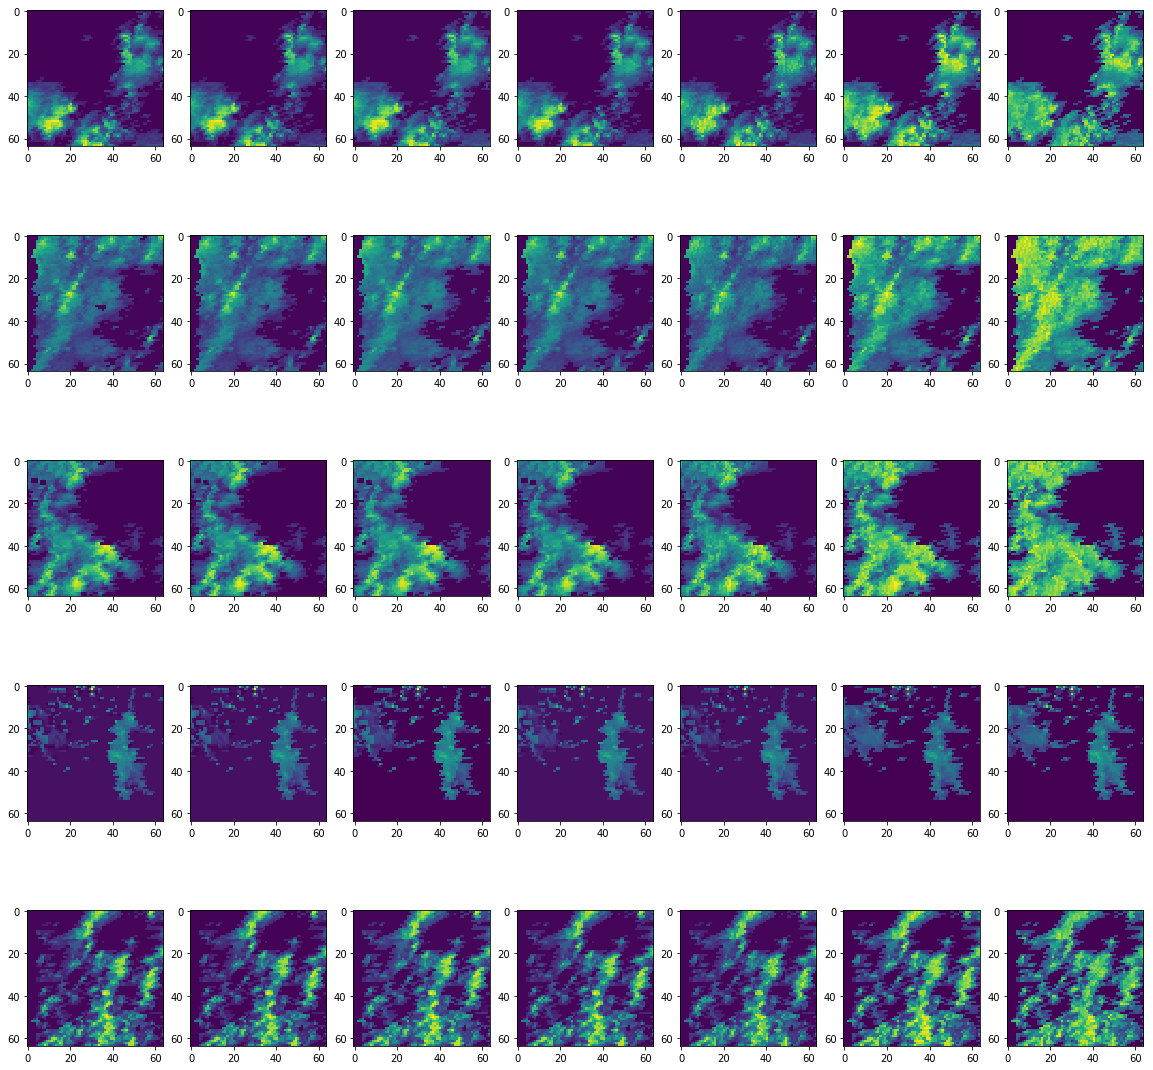

In [55]:
examples = 5

xs = []
with tf.Session() as sess:
    for _ in range(examples):
        xs.append(sess.run(data.make_one_shot_iterator().get_next()))

fig, ax = plt.subplots(figsize=(20,20), nrows=examples, ncols=n_bands)

for i in range(examples):
    for j in range(n_bands):
        ax[i][j].imshow(xs[i][:, :, j])
    

#### Training Parameters

In [56]:
optimizer = 'adam'
loss = 'mean_squared_error'
metrics = ['accuracy']

In [57]:
en, ae = model.autoencoder((img_width, img_width, n_bands))

en.compile('adam', loss='mse')
ae.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy']
)

ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_input (InputLayer)        (None, 64, 64, 7)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 16)        1024      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [ ]:
history = ae.fit(
    x=data.zip((data, data)).batch(32),
    epochs=10,
    steps_per_epoch=700,
    verbose=2,
)

Epoch 1/10
 - 255s - loss: 4969548.9782 - acc: 0.4544
Epoch 2/10
 - 254s - loss: 4698514.1590 - acc: 0.5389
Epoch 3/10
 - 260s - loss: 5202527.9717 - acc: 0.4198
Epoch 4/10
 - 264s - loss: 4452429.5605 - acc: 0.5274
Epoch 5/10


##### Get data

In [157]:
x = (data
    .batch(700)
    .make_one_shot_iterator()
    .get_next())

with tf.Session() as sess:
    x = sess.run(x)

In [158]:
en = en = tf.keras.models.Model(
    inputs=ae.input,
    outputs=ae.get_layer('conv2d_3').output
)
e = en.predict(x)
y = ae.predict(x)

# Analysis

#### AE results
Each column is a band, each pair of rows is the input and autoencoded output.

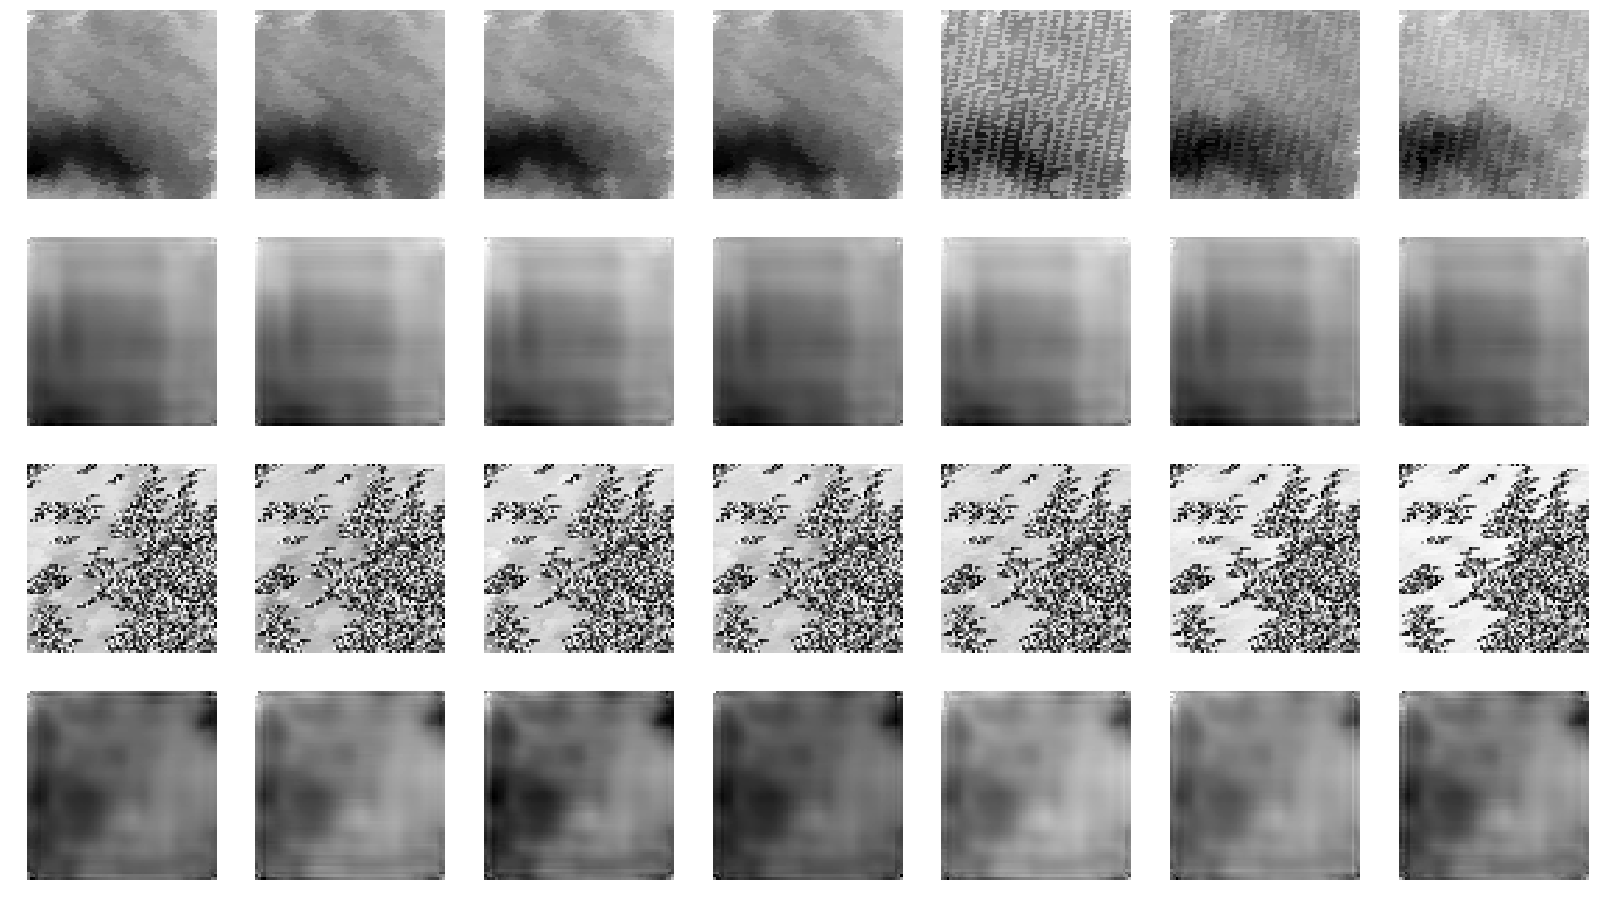

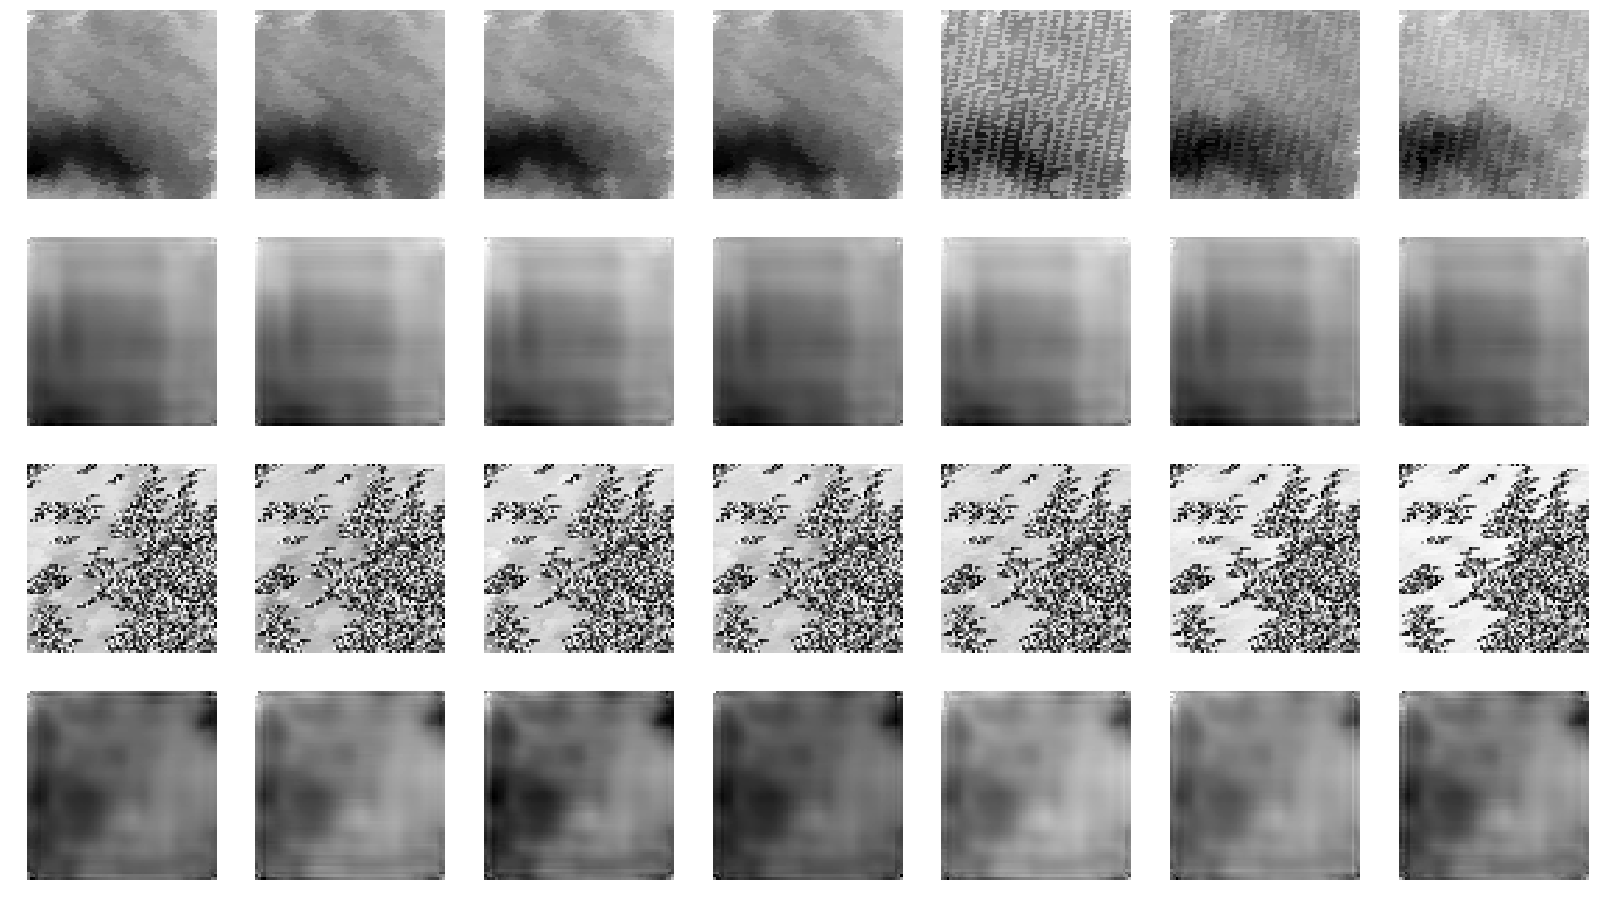

In [184]:
analysis.plot_ae_output(x, y, 2, n_bands)

### PCA Projection
* Below are the images projected onto the two principle components of the encoded space.
* The solid points represent clusters found by K Means (also projected down to principle components)
* Note that K-Means performs poorly in high dimensions

In [251]:
from scipy.cluster.vq import kmeans

In [ ]:
K = 3 # Number of means

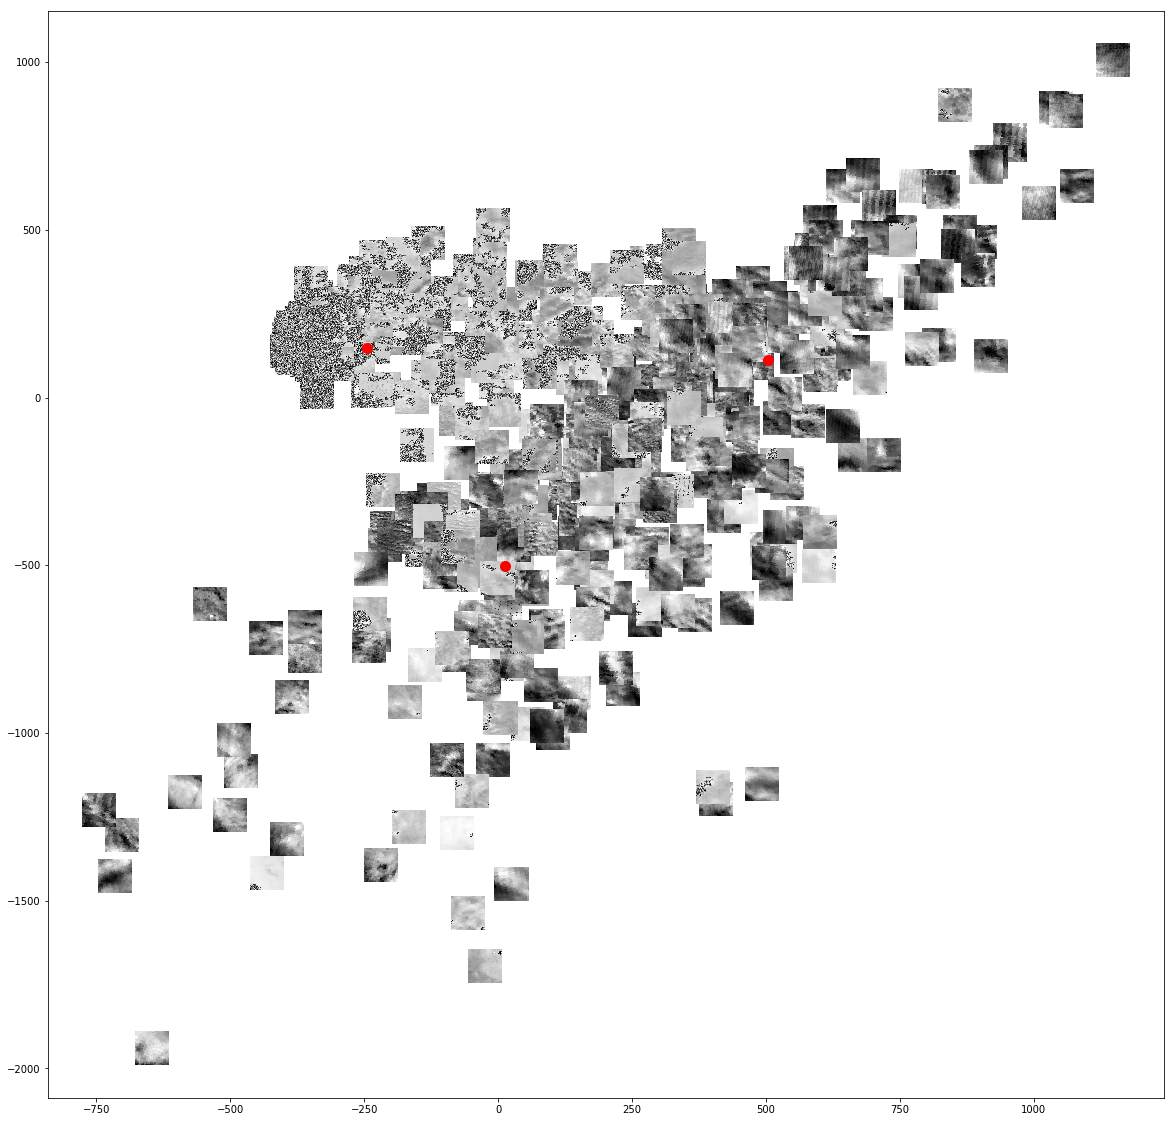

In [250]:
pc = analysis.PCA(e_)
proj = pc.project(e_, 2)
codebook, distortion = kmeans(e_, K)

_, ax = analysis.img_scatter(proj, x.mean(axis=3), zoom = 0.5)

xs, ys = pc.project(codebook,2).transpose()

ax.scatter(xs, ys, s=100, c='r', zorder=1000)


#### T-SNE

In [199]:
?vq.kmeans